In [2]:
from adelie.cv import cv_grpnet
from adelie import grpnet
import adelie as ad
import warnings
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# set seed
SEED = 7235
np.random.seed(SEED)

### Analysis Fuctions

In [5]:
# selected gene path
def selected_genes_path(betas, num_features, num_classes):
    """
    Computes the number of unique features (genes) selected for each lambda value in the returned lambda path of adeline cross-validation.

    Parameters:
    betas (scipy.sparse.csr_matrix): Betas over the lambda path (shape: (L, num_features * num_classes)).
    num_features (int): Number of features (genes).
    num_classes (int): Number of classes.

    Returns:
    list: Number of features selected for each lambda.
    """
    num_lambdas = betas.shape[0]  # Number of lambdas in the path
    selected_features_per_lambda = []

    for i in range(num_lambdas):
        # Extract coefficients for the current lambda and reshape to (num_features, num_classes)
        beta_dense = betas[i].toarray().reshape(num_features, num_classes)

        # Identify features (genes) that have non-zero coefficients across any class
        nonzero_features = np.any(beta_dense != 0, axis=1)
        selected_features_per_lambda.append(np.sum(nonzero_features))

    return selected_features_per_lambda

In [6]:
def num_selected_genes(beta, num_features, num_classes):
    """
    Computes the number of unique features (genes) selected for a specific beta.

    Parameters:
    beta (scipy.sparse.csr_matrix): Beta coefficients for a specific lambda (shape: (1, num_features * num_classes)).
    num_features (int): Number of features (genes).
    num_classes (int): Number of classes.

    Returns:
    int: Number of unique features selected for this beta.
    """
    # Reshape beta to (num_features, num_classes)
    beta_dense = beta.toarray().reshape(num_features, num_classes)

    # Count unique features (genes) that are non-zero across any class
    nonzero_features = np.any(beta_dense != 0, axis=1)
    return np.sum(nonzero_features)

In [7]:
def best_beta(state, cv_res, x, y):
    """
    Obtain best beta from cross validation.

    Parameters:
    state: state object from lasso solution.
    cv_res: cross validation object from adeline

    Returns:
    array: best beta from cross validation
    float: best mean loss associated with the best beta from cross validation
    """
    # obtain beta state
    betas = state.betas

    # transform y
    one_hot_encoder = OneHotEncoder(sparse_output=False)  # Use dense array
    yall_one_hot = one_hot_encoder.fit_transform(y.reshape(-1, 1))

    num_samples, num_features = x.shape
    num_classes = len(np.unique(y))

    # obtain best beta given lambda path
    mean_loss_per_lambda = cv_res.avg_losses
    best_lambda_idx = cv_res.best_idx
    best_lambda = cv_res.lmdas[best_lambda_idx]
    best_state = ad.grpnet(
        X=x,
        glm=ad.glm.multinomial(y=yall_one_hot, dtype=np.float64),
        lmda_path=[best_lambda],  # Fit only for the best lambda
        intercept=False
    )
    best_betas = best_state.betas  # Coefficients for the best lambda
    best_mean_loss = mean_loss_per_lambda[best_lambda_idx]
    num = num_selected_genes(best_betas, num_features, num_classes)
    print(f'best mean loss {best_mean_loss} with {num} features selected')
    return best_betas, best_mean_loss

In [8]:
# comparing with raw lasso
def compute_error_rate_multiclass(X, y, betas, num_features, num_classes):
    """
    Compute the error rate for each lambda based on predictions and true labels for multiclass classification.

    Parameters:
    X (ndarray): Feature matrix.
    y (ndarray): True labels (integer-encoded: 0, 1, ..., num_classes - 1).
    betas (scipy.sparse.csr_matrix): Coefficient matrix for each lambda.
    num_features (int): Number of features (genes).
    num_classes (int): Number of classes.

    Returns:
    list: Error rate for each lambda.
    """
    error_rates = []
    for beta in betas:
        # Reshape beta to (num_features, num_classes)
        beta_dense = beta.toarray().reshape(num_features, num_classes)

        # Predict logits
        logits = X @ beta_dense

        # Predict class labels
        y_pred_labels = np.argmax(logits, axis=1)

        # Compute error rate
        error_rate = np.mean(y_pred_labels != y)
        error_rates.append(error_rate)

    return error_rates

In [9]:
def get_error_rate_and_selected_genes(X, y, state, num_features, num_classes):
    """
    Computes the error rate and the number of selected genes (features) for each lambda.

    Parameters:
    X (ndarray): Feature matrix.
    y (ndarray): True labels (integer-encoded: 0, 1, ..., num_classes - 1).
    state (GrpnetState): The state object from Adelie, containing betas.
    num_features (int): Number of features (genes).
    num_classes (int): Number of classes.

    Returns:
    tuple: (list of error rates, list of selected genes for each lambda)
    """
    betas = state.betas  # Extract betas from the state object

    # Compute error rates for each lambda
    error_rates = compute_error_rate_multiclass(X, y, betas, num_features, num_classes)

    # Compute the number of selected genes for each lambda
    selected_genes = selected_genes_path(betas, num_features, num_classes)

    return error_rates, selected_genes

In [10]:
def plot_lasso_comparison_and_overlap(X, y, raw_state, variant_state, num_features, num_classes):
    """
    Plot scatter plots of raw Lasso vs. Lasso Variant and compute overlapping selected genes for multiclass classification.

    Parameters:
    X (ndarray): Feature matrix.
    y (ndarray): True labels (integer-encoded: 0, 1, ..., num_classes - 1).
    raw_state (GrpnetState): The state object from Adelie for raw Lasso.
    variant_state (GrpnetState): The state object from Adelie for Lasso Variant.
    num_features (int): Number of features (genes).
    num_classes (int): Number of classes.

    Returns:
    list: Overlapping genes for each lambda in the path.
    """
    # Extract betas
    raw_betas = raw_state.betas
    variant_betas = variant_state.betas

    # Compute error rates dynamically
    raw_error_rates = compute_error_rate_multiclass(X, y, raw_betas, num_features, num_classes)
    variant_error_rates = compute_error_rate_multiclass(X, y, variant_betas, num_features, num_classes)

    # Compute number of selected genes
    raw_selected_genes = selected_genes_path(raw_betas, num_features, num_classes)
    variant_selected_genes = selected_genes_path(variant_betas, num_features, num_classes)

    # Plot comparison
    plt.figure(figsize=(10, 6))
    plt.scatter(raw_selected_genes, raw_error_rates, c='black', label="Raw Lasso", alpha=0.7)
    plt.scatter(variant_selected_genes, variant_error_rates, c='green', label="Lasso Variant", alpha=0.7)
    plt.xlabel("Number of Genes Selected")
    plt.ylabel("Error Rate")
    plt.title("Comparison of Raw Lasso vs. Lasso Variant")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Compute overlapping genes for each lambda
    overlapping_genes = []
    for raw_beta, variant_beta in zip(raw_betas, variant_betas):
        # Reshape betas to (num_features, num_classes)
        raw_nonzero = np.any(raw_beta.toarray().reshape(num_classes, num_features).T != 0, axis=1)
        variant_nonzero = np.any(variant_beta.toarray().reshape(num_classes, num_features).T != 0, axis=1)

        # Find overlapping features (indices)
        overlap = np.where(raw_nonzero & variant_nonzero)[0]
        overlapping_genes.append(overlap)

    return overlapping_genes

### LASSO Variations

In [43]:
# obtain cross validation object and raw lasso state object
def raw_lasso(x, y, n_folds=7, plot=True):
    """
    Obtain cross validation object and raw lasso state object.

    Parameters:
    x (ndarray): shape of (samples,genes).
    y (array): shape of (samples,).
    n_folds (int): number of cross-validation folds.
    plot (bool): plot the cv graph and coefficient profile.

    Returns:
    ad.solver.GrpnetState: The state of the optimization, containing betas, lambda path, etc.
    ad.cv_grpnet.CVGrpnetResult: Cross-validation results object.
    """
    # process input data
    one_hot_encoder = OneHotEncoder(sparse_output=False)  # Use dense array
    yall_one_hot = one_hot_encoder.fit_transform(y.reshape(-1, 1))

    # cross validation
    cv_res = cv_grpnet(
        X=x,
        glm=ad.glm.multinomial(y=yall_one_hot, dtype=np.float64),
        min_ratio=1e-3,
        seed=SEED,
        intercept=False,
        n_folds=n_folds)
    if plot:
        cv_res.plot_loss()
        plt.show()

    # solving lasso with lambda path
    state = grpnet(
        X=x,
        glm=ad.glm.multinomial(y=yall_one_hot, dtype=np.float64), )
    if plot:
        dg = ad.diagnostic.diagnostic(state=state)
        dg.plot_coefficients()
        dg.plot_devs()
        plt.show()

    return state, cv_res

In [12]:
def inverse_weighted_lasso(X, y, importance_scores, n_folds=7, plot=True):
    """
    Perform inverse-weighted importance Lasso using Adelie.

    Parameters:
    X (np.ndarray): Feature matrix of shape (n_samples, n_features).
    y (np.ndarray): Target vector of shape (n_samples,) or one-hot encoded for multiclass.
    importance_scores (np.ndarray): Importance scores of shape (n_features,).
    n_folds (int): Number of folds for cross-validation.
    plot (bool): plot the cv graph and coefficient profile.

    Returns:
    ad.cv_grpnet.CVGrpnetResult: Cross-validation results object.
    ad.solver.GrpnetState: The state of the optimization, containing betas, lambda path, etc.
    """
    # process y
    one_hot_encoder = OneHotEncoder(sparse_output=False)  # Use dense array
    y_one_hot = one_hot_encoder.fit_transform(y.reshape(-1, 1))

    # Compute the penalty factors (inverse of importance scores)
    penalties = 1 / np.array(importance_scores)

    # Normalize penalties to ensure scale invariance
    penalties /= np.sum(penalties)

    # Define the group Lasso problem (each feature is treated as its own group)
    cv_res = ad.cv_grpnet(
        X=X,
        glm=ad.glm.multinomial(y=y_one_hot, dtype=np.float64),
        penalty=penalties,
        n_folds=n_folds,
        seed=SEED,
    )

    if plot:
        cv_res.plot_loss()
        plt.show()

    # Solve the Lasso problem
    state = ad.solver.grpnet(
        X=X,
        glm=ad.glm.multinomial(y=y_one_hot, dtype=np.float64),
        penalty=penalties,
    )

    if plot:
        dg = ad.diagnostic.diagnostic(state=state)
        dg.plot_coefficients()
        dg.plot_devs()
        plt.show()

    return state, cv_res

### Run an example

In [13]:
 # Load ash dataset
data = np.load('../LLM-Lasso/data/ash/cleaned_ash.npz', allow_pickle=True)

In [14]:
print("Keys in the npz file:", data.files)
xall = data['xall']
print(xall.shape)
yall = data['yall']
print(yall.shape)

Keys in the npz file: ['xall', 'yall', 'yclass', 'genenames']
(437, 1592)
(437,)


In [15]:
yclass = data['yclass']
yclass_unique = np.unique(data['yclass'])
genenames_unique = np.unique(data['genenames'])
print(len(yclass), len(yclass_unique), len(genenames_unique))

437 11 1592


  1%|          | 1/101 [00:00:00<00:00:26, 3.82it/s] [dev:12.2%]

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


100%|██████████| 100/100 [00:00:17<00:00:00, 5.64it/s] [dev:99.8%]


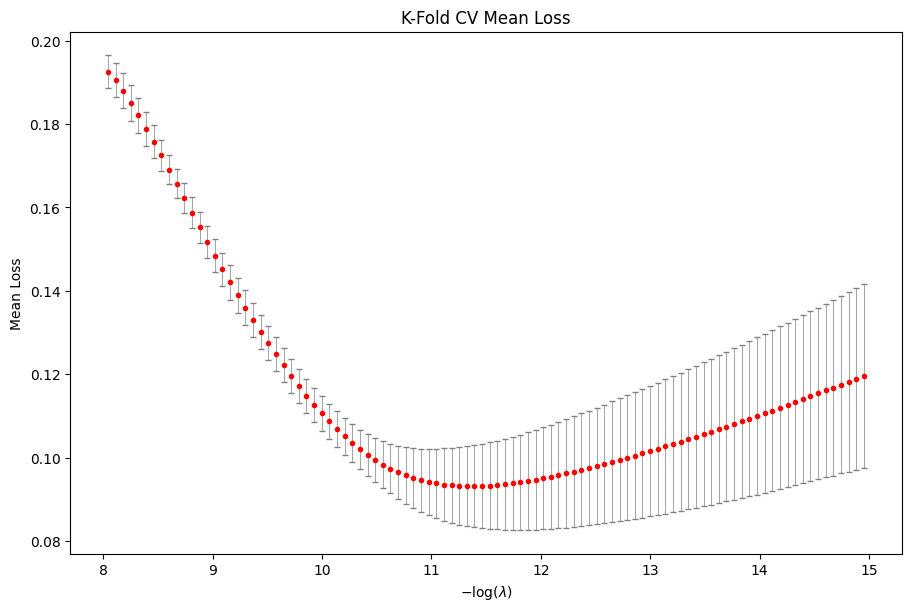

 80%|████████  | 80/100 [00:00:07<00:00:01, 11.32it/s] [dev:90.0%] 


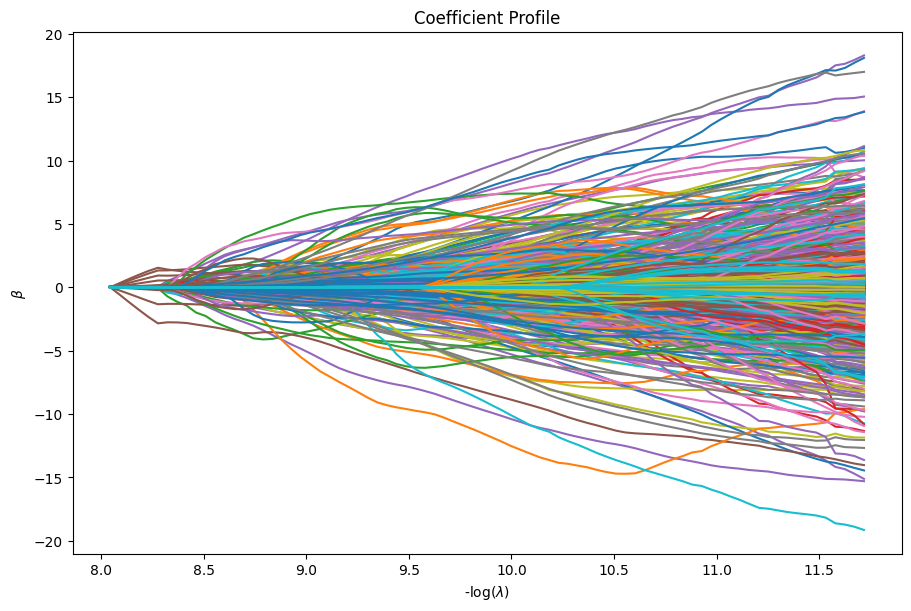

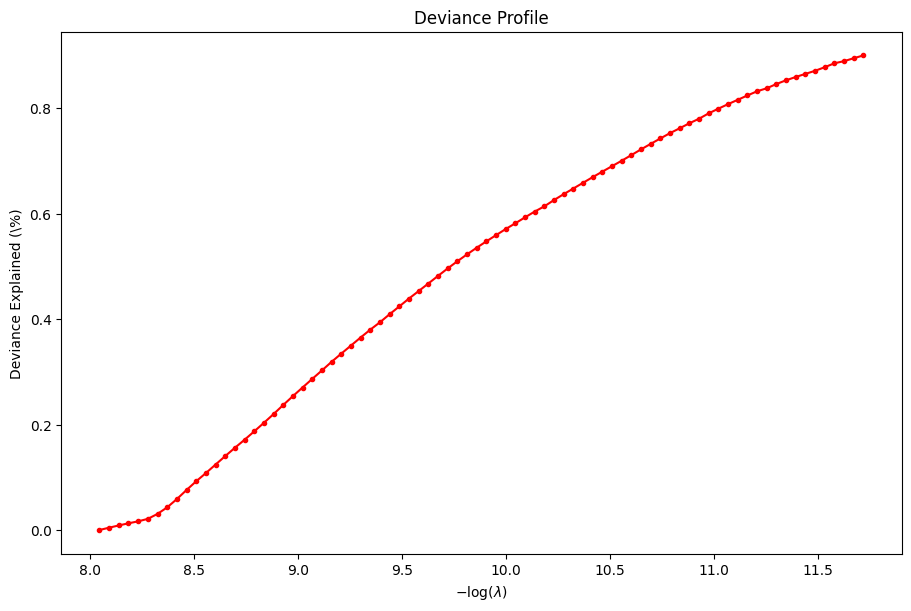

In [35]:
raw_state, raw_cv = raw_lasso(xall, yall, n_folds=2, plot=True)

In [40]:
xall

array([[0.1446355 , 0.1306194 , 0.1710231 , ..., 0.2580759 , 0.223718  ,
        0.2532655 ],
       [0.1097476 , 0.1253667 , 0.05507486, ..., 0.295257  , 0.2546138 ,
        0.2623069 ],
       [0.101388  , 0.1172749 , 0.1010945 , ..., 0.2892347 , 0.2388675 ,
        0.2617015 ],
       ...,
       [0.1124775 , 0.08424658, 0.07480469, ..., 0.2570779 , 0.2435281 ,
        0.2446481 ],
       [0.1143825 , 0.1227809 , 0.07592516, ..., 0.2726641 , 0.2425182 ,
        0.2510961 ],
       [0.1137482 , 0.1124858 , 0.1000212 , ..., 0.2352809 , 0.2338455 ,
        0.219237  ]])

### Very simple example: Validation

In [66]:
xall_simple = np.random.normal(0, 0.1, (100, 4))
xall_simple[0:50, 0] += 10
xall_simple[0:50, 1] -= 10
xall_simple[51:, 2] -= 10
xall_simple[51:, 3] += 10
yall_simple = np.array([0] * 50 + [1] * 50)

/home/nsagan/git-managed/adelie/adelie/matrix.py:648: UserWarning: Detected matrix to be C-contiguous. Performance may improve with F-contiguous matrix.
  warnings.warn(
100%|██████████| 100/100 [00:00:00<00:00:00, 23926.94it/s] [dev:99.9%]


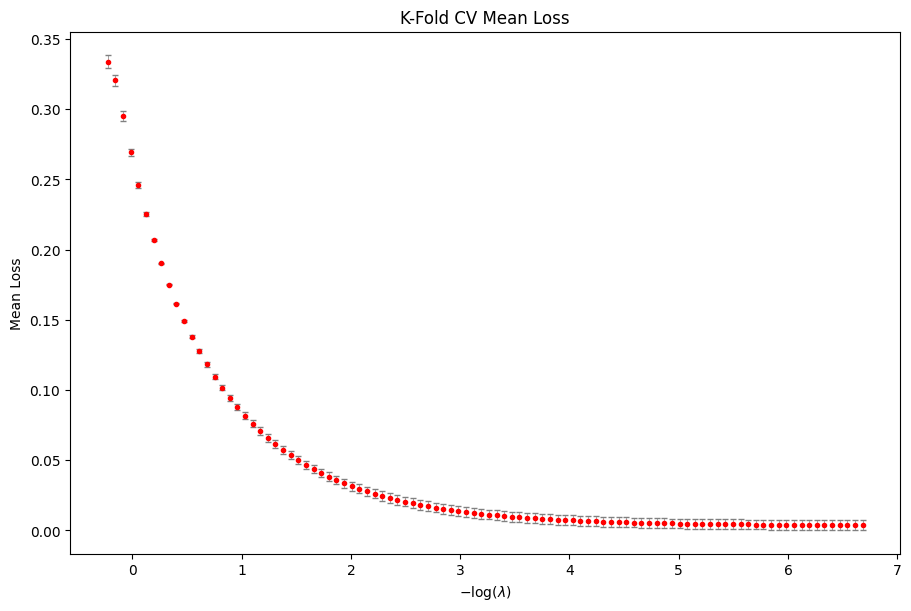

 45%|████      | 45/100 [00:00:00<00:00:00, 26371.12it/s] [dev:90.4%]


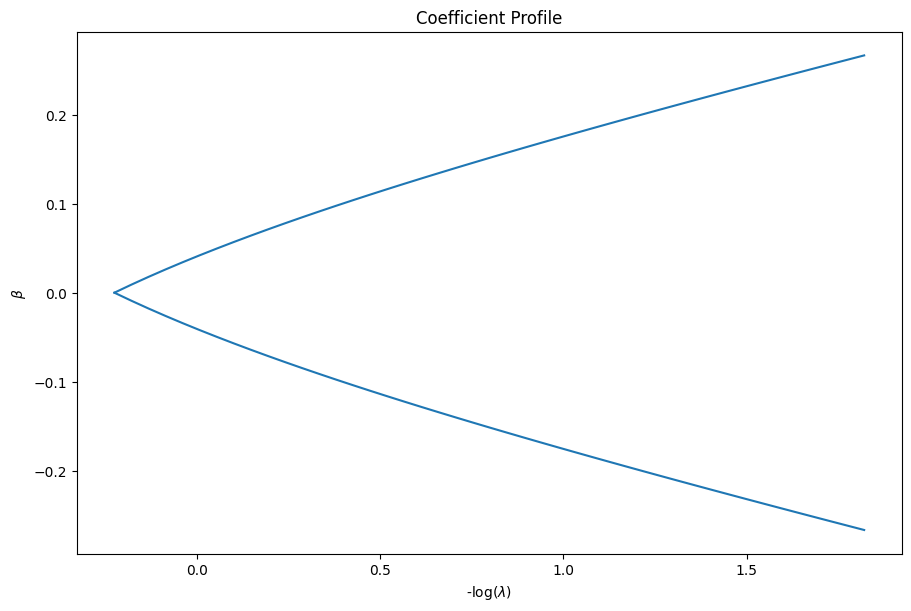

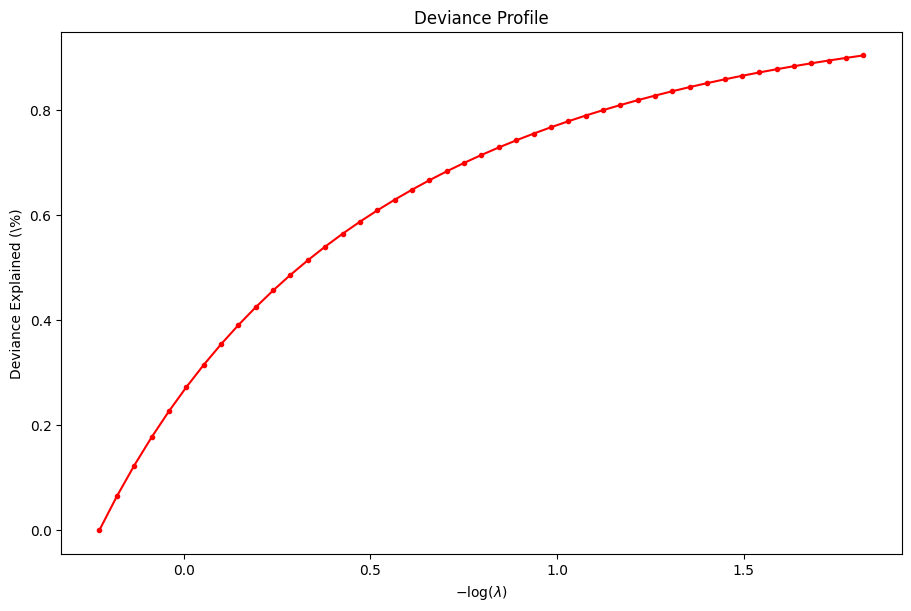

In [67]:
raw_state, raw_cv = raw_lasso(xall_simple, yall_simple, n_folds=2, plot=True)

In [73]:
raw_cv.betas.shape

(2, 2, 4)

In [77]:
raw_cv.betas[0][0], raw_cv.betas[1][0]

(array([ 0.31937655, -0.31937655, -0.05176194,  0.05176194]),
 array([ 0.       ,  0.       , -0.3745654,  0.3745654]))

In [78]:
raw_cv.betas[0][1], raw_cv.betas[1][1]

(array([ 0.        ,  0.        , -0.39008609,  0.39008609]),
 array([ 0.       ,  0.       , -0.3745654,  0.3745654]))